In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
import time 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
device_cpu = device
print( device )

mytype = torch.float16 # to save memory (only on GPU)
mytype = torch.float32


cuda:0


In [2]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 39.7 MB/s eta 0:00:00


# Download the data from a GitHub repo.

In [3]:
!mkdir data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/CC_all2_base_K_prot.data
!mv CC_all2_base_K_prot.data data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/Consensus_CompoundBioactivity_Dataset_v1.1_Sh2_all2.csv.zip
!mv Consensus_CompoundBioactivity_Dataset_v1.1_Sh2_all2.csv.zip data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/CC_train_arr.data
!mv CC_train_arr.data data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/CC_test_arr.data
!mv CC_test_arr.data data/

In [4]:
import pandas as pd
import zipfile
base_name = 'Consensus_CompoundBioactivity_Dataset_v1.1_Sh2_all2'
zf = zipfile.ZipFile('data/' + base_name + '.csv.zip') 
df = pd.read_csv(zf.open(base_name + '.csv'),low_memory=False)
df.rename(columns={'standardized smiles':'smiles'}, inplace=True)
df.head()

,smiles,fasta,ChEMBL ID,PubChem ID,IUPHAR ID,Ligand names,Target,uniprot,mean,pIC50,pKi,pKd,measure,score,interaction+,indsmiles,indfasta
0,BrC1CCN(Cc2ccc(OCCCN3CCCCC3)cc2)CC1,MERAPPDGPLNASGALAGEAAAAGGARGFSAAWTAVLAALMALLIV...,CHEMBL472466,44592131.0,NaN,4-bromo-1-(4-(3-(piperidin-1-yl)propoxy)benzyl...,hrh3,Q9Y5N1,9.7,NaN,9.7,NaN,9.7,1.0,True,0.0,0.0
1,BrCC(Br)C1CCC(Br)C(Br)C1,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,CHEMBL375107,18728.0,NaN,"1,2-dibromo-4-(1,2-dibromoethyl)cyclohexane\nn...",ar,P10275,7.4,7.4,NaN,NaN,7.4,1.0,True,1.0,1.0
2,Brc1c(C2=CN3CCC2CC3)oc2ccccc12,MANFTPVNGSSGNQSVRLVTSSSHNRYETVEMVFIATVTGSLSLVT...,CHEMBL415510,10494696.0,NaN,3-(3-bromo-benzofuran-2-yl)-1-aza-bicyclo[2.2....,chrm4,P08173,7.0,NaN,7.0,NaN,7.0,1.0,True,2.0,2.0
3,Brc1c(C2=CN3CCC2CC3)oc2ccccc12,MEGDSYHNATTVNGTPVNHQPLERHRLWEVITIAAVTAVVSLITIV...,CHEMBL415510,10494696.0,NaN,3-(3-bromo-benzofuran-2-yl)-1-aza-bicyclo[2.2....,chrm5,P08912,7.0,NaN,7.0,NaN,7.0,1.0,True,2.0,3.0
4,Brc1c(C2=CN3CCC2CC3)oc2ccccc12,MNNSTNSSNNSLALTSPYKTFEVVFIVLVAGSLSLVTIIGNILVMV...,CHEMBL415510,10494696.0,NaN,3-(3-bromo-benzofuran-2-yl)-1-aza-bicyclo[2.2....,chrm2,P08172,7.0,NaN,7.0,NaN,7.0,1.0,True,2.0,4.0


In [5]:
df_p = df[df['interaction+'] == True]
#list of smiles strings
dict_ind2smiles = df_p[['indsmiles','smiles']].set_index('indsmiles').to_dict()['smiles']
# ordonner les indices suivant les ind2mol
dict_ind2smiles = {k:dict_ind2smiles[k] for k in sorted(dict_ind2smiles.keys())}
print(len(dict_ind2smiles))
smiles = list(dict_ind2smiles.values())
len(smiles)

152844


152844

# mol kernel
Compute all Morgan Fingerprints.

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
import progressbar
nM =  len(smiles) #100000 #
MorganFP = np.zeros((nM,1024))
for i in progressbar.progressbar(range(nM)):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles[i])    
    # Generate Morgan fingerprint of the molecule
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    # Convert the fingerprint to a numpy array
    arr = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    MorganFP[i,:] = arr
MorganFP = MorganFP.astype(int)

100% (152844 of 152844) |################| Elapsed Time: 0:01:17 Time:  0:01:17


In [7]:
# go to GPU to compute the kernel
MorganFP = torch.tensor(MorganFP, dtype=mytype).to(device)

Select a random subset $S$ of $k$ molecules.

In [8]:
k = 3000 # number of molecule to compute nystrom
rM = 500 # final dimension of features for molecules
S = np.random.permutation(nM)[:k]

Compute Tanimoto kernel between $S$ and all the molecules. When viewed as vectors of $\{0,1\}$ $x=1_A$, $y=1_B$, the formula is 
$$
  K(x,y) = \frac{|A \cap B|}{|A \cup B|}
  = \frac{|A \cap B|}{1024 - |A^c \cap B^c|}
  = \frac{\langle x,y \rangle}{1024 - \langle 1-x,1-y \rangle}
$$

In [9]:
tic = time.perf_counter()
K = ( MorganFP[S,:] @ MorganFP.T ) / ( 1024 - (1-MorganFP[S,:]) @ (1-MorganFP.T) )
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

time: 2.8990 seconds


In [10]:
K.shape

torch.Size([3000, 152844])

Apply Nyström

time: 5.5825 seconds


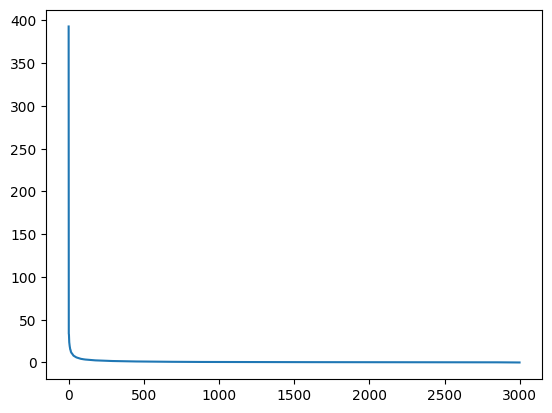

In [11]:
tic = time.perf_counter()
U, Lambda, VT = torch.svd(K[:,S])
epsi = 1e-8  # be careful when we divide by Lambda near 0
X = K.T @ U[:,:rM] @ torch.diag(1./torch.sqrt(epsi + Lambda[:rM]))
print(f"time: {time.perf_counter() - tic:0.4f} seconds")
plt.plot(Lambda.cpu())

In [12]:
X.shape

torch.Size([152844, 500])

Normalise X

In [13]:
X_c = X - X.mean(axis = 0)
X_cn = X_c / torch.norm(X_c,dim = 1)[:,None] 

# prot kernel

Load protein kernel and compute its features $Y$.

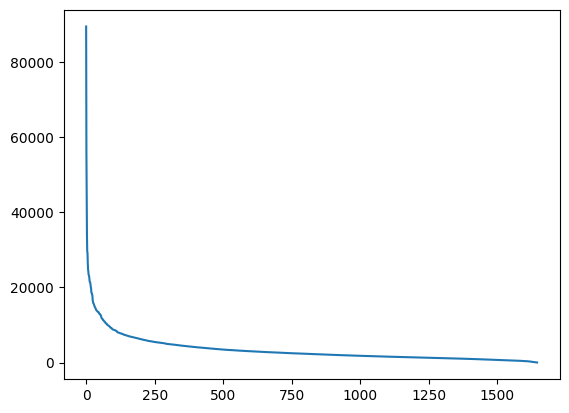

In [14]:
import pickle
with open('data/CC_all2_base_K_prot.data', 'rb') as f:
  KP = pickle.load(f)
KP = torch.tensor(KP, dtype=mytype).to(device)
# computation of feature for protein (no nystrom, just PCA)
rP = KP.shape[0]#min(KP.shape[0],500)
U, Lambda, VT = torch.svd(KP)
Y = U[:,:rP] @ torch.diag(torch.sqrt(Lambda[:rP]))
torch.norm(KP - Y@Y.T)/torch.norm(KP)
plt.plot(Lambda.cpu())

Normalise Y

In [15]:
Y_c = Y - Y.mean(axis = 0)
Y_cn = Y_c / torch.norm(Y_c,dim = 1)[:,None]

# train

In [16]:
# protein indices
J0 = df_p['indfasta'].values # proteins
# molecules indices
I0 = df_p['indsmiles'].values # molecule
print(len(I0), len(J0))

# load with pickle
import pickle
with open('data/CC_train_arr.data', 'rb') as f:
        arr_train = pickle.load(f)

i_fold = 0
train = arr_train[i_fold]
print(len(train))

229012 229012
366418


In [17]:
J0 = train[:,0] # proteins
I0 = train[:,1] # molecules
y = train[:,2] # labels

In [18]:
# sub-select those I and J within the loaded database
I = I0[I0<nM]
J = J0[I0<nM]
y = y[I0<nM]
I = torch.tensor(I, dtype=torch.long).to(device)
J = torch.tensor(J, dtype=torch.long).to(device)
y = torch.tensor( np.sign(y-.5) ).to(device)
n = len(I)
print(n)

366418


In [19]:
# compute the features of the Kronecker kernel for the train
XI, YJ = X_cn[I,:], Y_cn[J,:]
def U(w): return torch.sum( (YJ@w) * XI, axis=1 )
def U(w): return torch.sum( (Y_cn@w)[J,:] * XI, axis=1 ) # FAST
def UT(z): return YJ.T @ ( z[:,None] * XI )  # TODO : modify this

In [ ]:
# a comparison of 2 ways to apply YJ

w = torch.randn(rP,rM).to(device)

tic = time.perf_counter()
z = torch.sum( (YJ@w) * XI, axis=1 )
a = torch.norm(z).item()
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

tic = time.perf_counter()
z = torch.sum( (Y@w)[J,:] * XI, axis=1 )
a = torch.norm(z).item()
print(f"time: {time.perf_counter() - tic:0.4f} seconds")


time: 0.1954 seconds
time: 0.0174 seconds


In [ ]:
w = torch.randn(rP,rM).to(device)
z = torch.randn(n).to(device)

tic = time.perf_counter()
z = U(w)
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

tic = time.perf_counter()
z = U(w)
z[0].item()
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

tic = time.perf_counter()
w = UT(z)
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

time: 0.0004 seconds
time: 0.0329 seconds
time: 0.0008 seconds


In [ ]:
!nvidia-smi

Thu Apr  6 12:02:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    40W /  70W |   9683MiB / 15360MiB |     58%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# SVM


In [20]:
def Loss(u): return 1/n * torch.sum(torch.maximum(1+u,torch.tensor(0)))
lamb = 1e-06
def g(w,b): return Loss(-y * (U(w)+b)) + lamb/2 * (w**2).sum() 

In [21]:
# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = g(w_bfgs,b_bfgs)
    objective.backward()
    return objective

w_bfgs = torch.randn(rP,rM).to(device)
b_bfgs = torch.randn(1).to(device)
w_bfgs.requires_grad = True
b_bfgs.requires_grad = True

lbfgs = optim.LBFGS([w_bfgs,b_bfgs],
                    history_size=10,
                    max_iter=4,
                    line_search_fn="strong_wolfe")
niter = 50
history_lbfgs = []
tic = time.perf_counter()
for i in range(niter):
    history_lbfgs.append(g(w_bfgs,b_bfgs).item())
    lbfgs.step(closure)
print(f"time: {time.perf_counter() - tic:0.4f} seconds")
print( g(w_bfgs,b_bfgs) )

time: 9.2653 seconds
tensor(0.0840, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


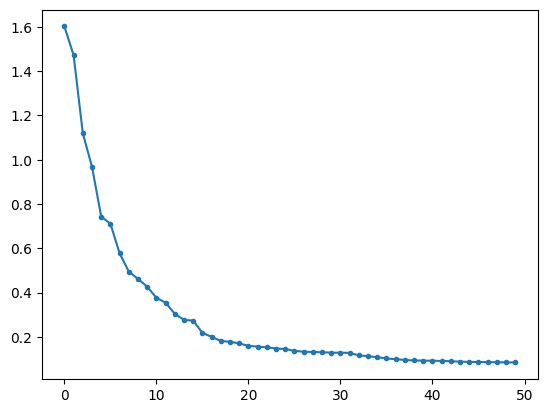

In [22]:
plt.plot( torch.tensor( history_lbfgs ), '.-' );

# prediction

In [23]:
# prediction
with open('data/CC_test_arr.data', 'rb') as f:
        test_arr = pickle.load(f)
test = test_arr[i_fold]
J0_test = test[:,0] # proteins  #IP_test
I0_test = test[:,1] # molecules IM_test
y_test = test[:,2] # labels


In [24]:

# sub-select those I and J within the loaded database
I_test = I0_test[I0_test<nM]
J_test = J0_test[I0_test<nM]
y_test = y_test[I0_test<nM]

I_test = torch.tensor(I_test, dtype=torch.long).to(device)
J_test = torch.tensor(J_test, dtype=torch.long).to(device)
y_test = torch.tensor( np.sign(y_test-.5) ).to(device)
n_test = len(I_test)
print(n_test)

91606


In [25]:
#I_test = I_test.type(torch.long)
#J_test = J_test.type(torch.long)

# compute the features of the Kronecker kernel
XI_test = X_cn[I_test,:].to(device)
YJ_test = Y_cn[J_test,:].to(device)
print(XI_test.shape,YJ_test.shape)

def U_test(w): 
  #w = w.reshape(rP,rM)
  return torch.sum( (Y_cn@w)[J_test,:] * XI_test, axis=1 )

pr_f = torch.sign( U_test(w_bfgs).detach() + b_bfgs.detach() )

torch.Size([91606, 500]) torch.Size([91606, 1647])


In [26]:
print("accuracy", torch.sum( y_test == pr_f ) / len(y_test) )

accuracy tensor(0.9684, device='cuda:0')


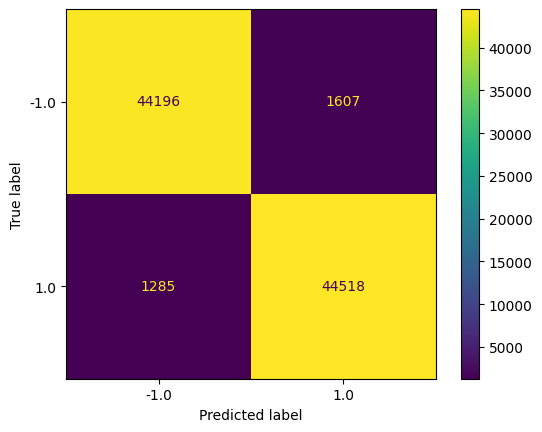

In [27]:
# plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [-1., 1.]
cm = confusion_matrix(y_test.cpu().numpy(), pr_f.cpu().numpy(),labels = labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()

plt.show()

Vérification test/train

In [28]:
S_train = set(map(tuple, train))
S_test = set(map(tuple, test))
print("number of pairs in train and test:",len(S_train.intersection(S_test)))

number of pairs in train and test: 0


Plot accuracy in function of lambda

In [ ]:
# calculate accuraccy for differetn lmabda
lambdas = np.logspace(-12, 3, num=16)
accs = []
for lamb in lambdas:
  def g(w,b): return Loss(-y * (U(w)+b)) + lamb/2 * (w**2).sum() 

  # L-BFGS
  def closure():
      lbfgs.zero_grad()
      objective = g(w_bfgs,b_bfgs)
      objective.backward()
      return objective

  w_bfgs = torch.randn(rP,rM).to(device)
  b_bfgs = torch.randn(1).to(device)
  w_bfgs.requires_grad = True
  b_bfgs.requires_grad = True

  lbfgs = optim.LBFGS([w_bfgs,b_bfgs],
                      history_size=10,
                      max_iter=4,
                      line_search_fn="strong_wolfe")
  niter = 20
  history_lbfgs = []
  tic = time.perf_counter()
  for i in range(niter):
      history_lbfgs.append(g(w_bfgs,b_bfgs).item())
      lbfgs.step(closure)
  print(f"time: {time.perf_counter() - tic:0.4f} seconds")
  print( g(w_bfgs,b_bfgs) )

  pr_f = torch.sign( U_test(w_bfgs).detach() + b_bfgs.detach() )
  acc = torch.sum( y_test == pr_f ) / len(y_test)
  accs.append(acc.item())
  print("lambda=",lamb,"accuracy=",acc.item())

time: 3.7788 seconds
tensor(0.0619, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-12 accuracy= 0.9554287195205688
time: 3.7252 seconds
tensor(0.0532, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-11 accuracy= 0.9560727477073669
time: 3.7150 seconds
tensor(0.0550, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-10 accuracy= 0.957273542881012
time: 3.8657 seconds
tensor(0.0132, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-09 accuracy= 0.9607667922973633
time: 3.7200 seconds
tensor(0.0543, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-08 accuracy= 0.9561273455619812
time: 3.7613 seconds
tensor(0.0940, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-07 accuracy= 0.9573827385902405
time: 3.6731 seconds
tensor(0.2427, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
lambda= 1e-06 accuracy= 0.9572080373764038
time: 3.8603 s

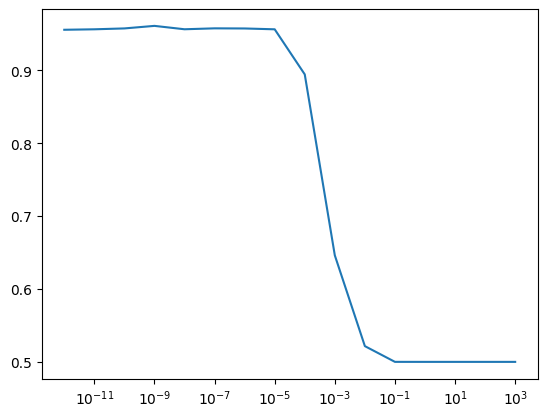

In [ ]:
plt.plot(lambdas,accs)
plt.xscale('log')
plt.show()

# Platt scaling

Once the weight $w$ have been computed, Platt scaling compute a probability using the formula
$$
    p_i := \sigma(-y_i ( s \langle x_i,w \rangle + t ))
    \text{ where }
    \sigma(u)=\frac{e^u}{1+e^u}
$$
where the scale $s$ (leven of confidence in some sense) and offset $t$ needs to be optimized. They are found by minimlizing the same energy as the logistic classification.
$$
    \min_{s,t} E(s,t) := \sum_i \ell(-y_i ( s \langle x_i,w \rangle + t)) 
    = L( - y \odot (s m  + t ) )
$$
where $\ell(u) := \log( 1 + e^u )$ and $m:=Xw$.

In [29]:
m = U_test(w_bfgs).detach() # do not forget to detach (do not backprop through it)!

In [30]:
def E(s,t): return 1/n * torch.sum( torch.log( 1+torch.exp(-y_test*(s*m+t)) ) )

In [31]:
# L-BFGS
def closure():
    lbfgs.zero_grad()
    objective = E(s,t)
    objective.backward()
    return objective
s = torch.ones(1).to(device)
t = torch.zeros(1).to(device)
s.requires_grad = True
t.requires_grad = True
lbfgs = optim.LBFGS([s,t],
                    history_size=10,
                    max_iter=4,
                    line_search_fn="strong_wolfe")
niter = 20
history_lbfgs = []
for i in range(niter):
    history_lbfgs.append(E(s,t).item())
    lbfgs.step(closure)

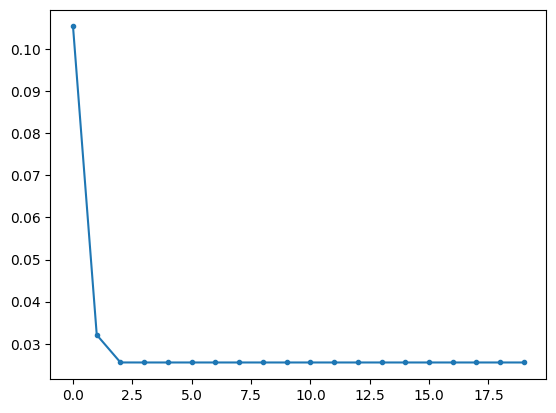

In [32]:
plt.plot( history_lbfgs, '.-' ) 

In [33]:
print(E(s,t))

tensor(0.0255, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


In [34]:
def sigma(u): return torch.exp(u) / (1+torch.exp(u))
p = sigma( (s*m+t) ).detach()

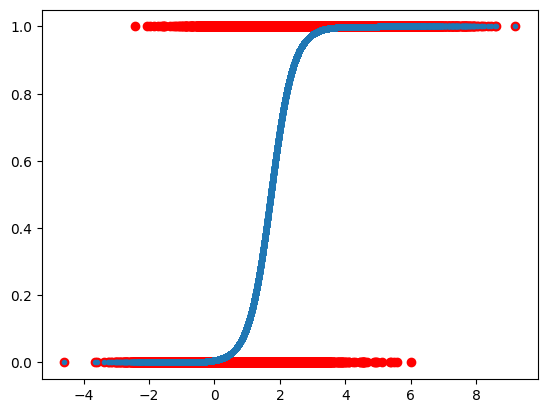

In [35]:
plt.plot( m.cpu().numpy(), (y_test.cpu()+1)/2, 'ro' )

plt.plot( m.cpu().numpy(), p.cpu().numpy(), '.' )

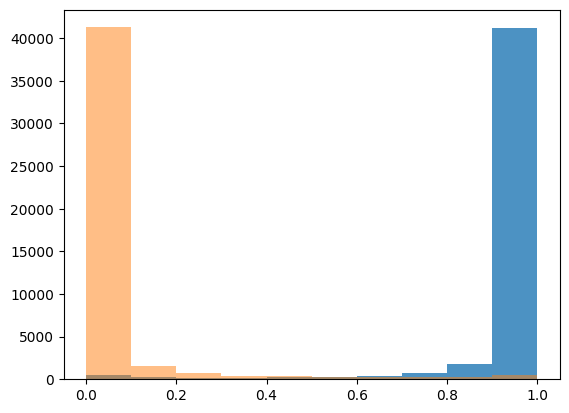

In [36]:
# plot distribution (density) of p when y_test=1
plt.hist(p.cpu().numpy()[y_test.cpu().numpy()==1],bins=10,alpha=0.8);
plt.hist(p.cpu().numpy()[y_test.cpu()==-1],bins=10,alpha=0.5);
plt.show()

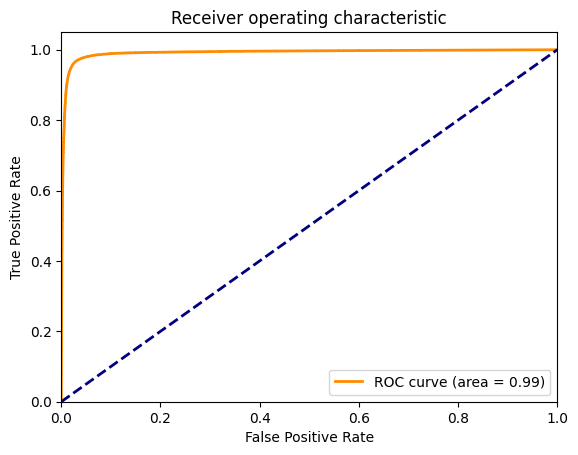

In [37]:
# plot ROC curve et afficher roc auc
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), p.cpu().numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

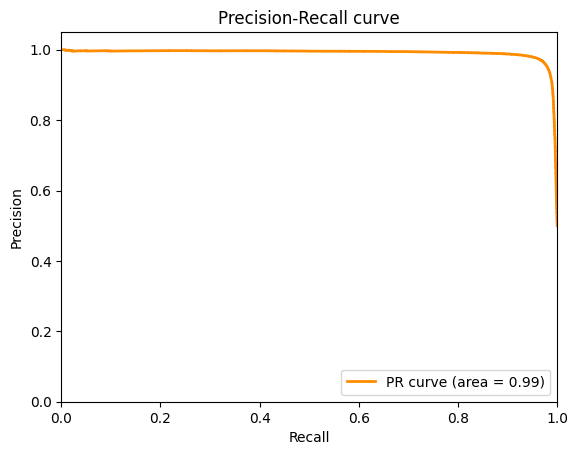

In [38]:
# plot PR curve et afficher AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test.cpu().numpy(), p.cpu().numpy())
average_precision = average_precision_score(y_test.cpu().numpy(), p.cpu().numpy())
plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
            lw=lw, label='PR curve (area = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

# faire tsne sur les features (de petites dim) avec les mol pour lesquelles il y a des erreurs et rajouter mes 20 mols

In [39]:
I_false = (I_test[y_test != pr_f])
print(len(I_test),len(I_false))

91606 2892


In [40]:
smiles_test = list(set(np.array(smiles)[I_test.cpu()]))
smiles_false = list(set(np.array(smiles)[I_false.cpu()]))

In [5]:
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/20_mol.csv
!mv 20_mol.csv data/

In [6]:
df_20mol =  pd.read_csv("data/20_mol.csv") 
df_20mol

,DBID,smile
0,1_10,Cl.O=C(c1ccc(Nc2nccc(n2)c2cc3c(cccc3)s2)cc1)N1...
1,1_11,O=C(N)Nc1sc(cc1C(=O)N)c1ccc(cc1)F
2,1_12,C1=CC=C(C(=C1)N)SC(=C(C#N)C(=C(N)SC2=CC=CC=C2N...
3,1_13,Cc1c(ccc(c1)I)Nc1c(cc(c(F)c1F)F)C(NOCC1CC1)=O
4,1_14,O[C@@H]1[C@@H](CO)O[C@@H](N2C3=C(C4=NC=N3)C(C(...
5,1_15,Nc1ncnc2n(nc(c3ccc(cc3)Cl)c21)C(C)(C)C
6,1_16,CN1C=C(C=C2C(=O)NC3=CC=CN=C23)C2=C1C=CC=C2
7,1_1,C1CC(C1)(C2=CC=C(C=C2)C3=C(C=C4C(=N3)C=CN5C4=N...
8,1_2,COC1=C(C(=CC=C1)F)C2=NCC3=CN=C(N=C3C4=C2C=C(C=...
9,1_3,CCS(=O)(=O)NC1=CC2=C(C=C1)NC(=O)C2=C(C3=CC=CC=...


In [ ]:
smiles = smiles_false + df_20mol.smile.to_list() 

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import progressbar
nM =  len(smiles) #100000 #
MorganFP = np.zeros((nM,1024))
for i in progressbar.progressbar(range(nM)):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles[i])    
    # Generate Morgan fingerprint of the molecule
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    # Convert the fingerprint to a numpy array
    arr = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    MorganFP[i,:] = arr
MorganFP = MorganFP.astype(int)

100% (2603 of 2603) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [ ]:
# go to GPU to compute the kernel
MorganFP = torch.tensor(MorganFP, dtype=mytype).to(device)

In [ ]:
tic = time.perf_counter()
K_2 = ( MorganFP @ MorganFP.T ) / ( 1024 - (1-MorganFP) @ (1-MorganFP.T) )
print(f"time: {time.perf_counter() - tic:0.4f} seconds")

time: 0.0006 seconds


In [ ]:
D = torch.sqrt(1-K_2)

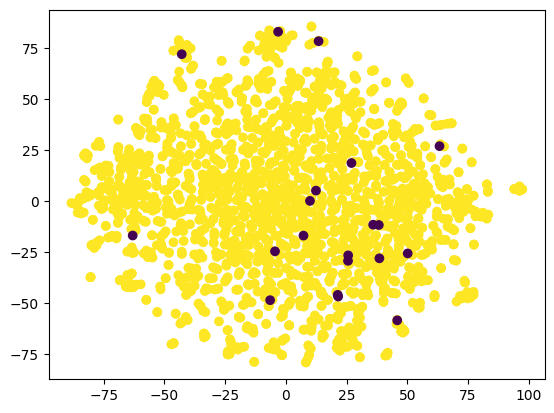

In [ ]:
# faire tsne avec matrice de distance DM
import sklearn
from sklearn.manifold import TSNE


# Visualisation using T-SNE on distance matrix
# Fit D_mol_Morgan into an embedded space of dimension 2 and return that transformed output Y.

perp = 10 # increase for less randomness
Y = sklearn.manifold.TSNE(n_components=2, perplexity=perp, init="random", metric = "precomputed").fit_transform(D.cpu().numpy())

plt.scatter(Y[:,0], Y[:,1],c=[True]*(len(smiles_2)-20)+[False]*20);

add the name of the 20_mol

See if the 20 mol are in the database. similarity for mol in the database ?

In [8]:
pd.merge(df_20mol, df, left_on='smile',right_on='smiles')

,DBID,smile,smiles,fasta,ChEMBL ID,PubChem ID,IUPHAR ID,Ligand names,Target,uniprot,mean,pIC50,pKi,pKd,measure,score,interaction+,indsmiles,indfasta


TSNE with 4 colors : mol in train, mol in test miscategorized, mol in test well categorized, 20 mol